### Códigos de la autora sobre equilibrio de Nash

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gurobipy import Model, GRB
import re
import random

# Configuración visual
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'

# Archivos de entrada
converge_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\RESULTADOS_P_PP_1.dat"
parametros_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\beneficios_capacidades_1.dat"
pps_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\NODOS_PROPORCIONES_10.dat"
all_pps_file = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\Resultados_v1.dat"

# Leer resultados de programas
resultados_df = pd.read_csv(converge_file, sep='\t', names=['Programa', 'Probabilidad', 'Lugares'], engine='python')
resultados_df['Lugares'] = resultados_df['Lugares'].str.strip('),').str.replace(r'[^\d,]', '', regex=True)

pps_df = pd.read_csv(pps_file, sep='\t', names=['pp', 'Probabilidad'], engine='python')
all_pps_df = pd.read_csv(all_pps_file, sep='\t', names=["instancia",  "n", "j", "pj", "pp", "tiempo", "x","gamma"], engine='python').drop(columns=["gamma", "x", "tiempo", "pj"])

# Leer parámetros desde el archivo DAT
with open(parametros_file, 'r') as file:
    parametros_lines = file.readlines()

# Procesar conjuntos y parámetros
I = list(map(int, re.findall(r'\d+', parametros_lines[0])))
L = list(map(int, re.findall(r'\d+', parametros_lines[2])))

BI, BL, KI, KL = {}, {}, {}, {}
Perd, M = None, None
reading_section = None

for line in parametros_lines:
    if 'param BI :=' in line:
        reading_section = 'BI'
    elif 'param BL :=' in line:
        reading_section = 'BL'
    elif 'param KI :=' in line:
        reading_section = 'KI'
    elif 'param KL :=' in line:
        reading_section = 'KL'
    elif 'param Perd :=' in line:
        Perd = int(re.search(r'\d+', line).group())
    elif 'param M :=' in line:
        M = int(re.search(r'\d+', line).group())
    elif ';' in line:
        reading_section = None
    elif reading_section:
        key, value = re.findall(r'\d+', line)
        if reading_section == 'BI':
            BI[int(key)] = float(value)
        elif reading_section == 'BL':
            BL[int(key)] = float(value)
        elif reading_section == 'KI':
            KI[int(key)] = float(value)
        elif reading_section == 'KL':
            KL[int(key)] = float(value)

# Parámetro G
G = max(max(BI.values(), default=0), max(BL.values(), default=0))

def resolver_con_gurobi(Pmg):
    model = Model("SistemaEcuaciones")
    model.Params.OutputFlag = 0

    gamma = model.addVar(vtype=GRB.CONTINUOUS, name="gamma")
    pp_vars = {j: model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f"pp_{j}") for j in I + L}
    y_vars = {j: model.addVar(vtype=GRB.BINARY, name=f"y_{j}") for j in I + L}

    for j in I + L:
        capacidad = KI[j] if j in I else KL[j]
        beneficio = BI[j] if j in I else BL[j]

        model.addConstr(
            G * (1 - y_vars[j]) + beneficio * (1 - pp_vars[j] * (M / capacidad)) * (1 - Pmg[j]) - Perd * Pmg[j] >= gamma,
            name=f"restriccion1_{j}"
        )
        model.addConstr(
            beneficio * (1 - pp_vars[j] * (M / capacidad)) * (1 - Pmg[j]) - Perd * Pmg[j] <= gamma,
            name=f"restriccion2_{j}"
        )
        model.addConstr(pp_vars[j] <= y_vars[j], name=f"restriccion3_{j}")

    model.addConstr(sum(pp_vars[j] for j in I + L) == 1, name="suma_proporciones")
    model.setObjective(gamma, GRB.MINIMIZE)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        raise ValueError("No se pudo encontrar una solución óptima.")

    soluciones = {
        'gamma': gamma.X,
        **{j: {'pp': pp_vars[j].X, 'y': y_vars[j].X} for j in I + L}
    }
    return soluciones

def simulacion_monte_carlo(dias_validos_deseados=150):
    Pmg = {j: 0 for j in I + L}
    proporciones_ilegales = []
    dias_validos = []

    dia = 1
    while len(proporciones_ilegales) < dias_validos_deseados:
        programa_seleccionado = random.choices(
            resultados_df['Programa'],
            weights=resultados_df['Probabilidad'],
            k=1
        )[0]

        lugares_inspeccionados = list(map(int, resultados_df[resultados_df['Programa'] == programa_seleccionado]['Lugares'].values[0].split(',')))
        x_dia = {j: 1 if j in lugares_inspeccionados else 0 for j in I + L}

        for j in Pmg:
            Pmg[j] = (Pmg[j] * (dia - 1) + x_dia[j]) / dia

        try:
            soluciones = resolver_con_gurobi(Pmg)
            suma_ilegales = sum(soluciones[j]['pp'] for j in I)
            proporciones_ilegales.append(suma_ilegales * 100)
            dias_validos.append(len(proporciones_ilegales) - 1)
        except Exception:
            pass

        dia += 1

      # === GRAFICO ===
    plt.figure(figsize=(16, 6))
    plt.plot(dias_validos, proporciones_ilegales, color='black', linewidth=2, zorder=3)
    plt.axhline(y=52, color='black', linestyle=':', linewidth=1.5, label=r'$I_{OR} = 52\%$', zorder=2)

    plt.xlabel("Periods", fontsize=27, labelpad=15)
    plt.ylabel(r"$I_{OR}(\tau)$", fontsize=27, labelpad=15)

    max_y = max(proporciones_ilegales) + 1
    plt.ylim(40, max_y)
    plt.xticks(ticks=range(0, dias_validos_deseados + 1, 15), fontsize=17)

    ticks_y = sorted(set([y for y in np.arange(50, np.ceil(max_y / 10) * 10, 5)] + [52]))
    plt.gca().set_yticks(ticks_y)
    plt.gca().set_yticklabels([f"{int(t)}\\%" for t in ticks_y], fontsize=17, color='black')

    plt.grid(False)
    plt.tight_layout()

    ruta_guardado = r"C:\Users\nico_\Desktop\Procesos\Proyecto\JavieraSimulations\simulacion_montecarlo1.pdf"
    plt.savefig(ruta_guardado, format='pdf', dpi=300)
    plt.show()

    print(f"Gráfico guardado en: {ruta_guardado}")

    # === ESTADÍSTICAS ===
    if proporciones_ilegales:
        ior_inicial = proporciones_ilegales[0]
        ior_min = min(proporciones_ilegales)
        ior_argmin = np.argmin(proporciones_ilegales)

        ior_media_estacionaria = np.mean(proporciones_ilegales[-100:])
        dia_baja_52 = next((i for i, val in enumerate(proporciones_ilegales) if val <= 52), None)

        print("\n=== Estadísticas IOR ===")
        print(f"IOR inicial: {ior_inicial:.2f}%")
        print(f"IOR mínima: {ior_min:.2f}%")
        print(f"IOR promedio últimos 100 días: {ior_media_estacionaria:.2f}%")
        if dia_baja_52 is not None:
            print(f"Día relativo en que baja de 52%: {dia_baja_52}")
            return dia_baja_52
        else:
            print("No se alcanzó una IOR menor o igual al 52% en la simulación.")
            return ior_argmin
# # Ejecutar simulación
# simulacion_monte_carlo(dias_validos_deseados=150)


In [2]:
print(len(I)) #Cantidad de lugares ilegales
print(len(L)) #Cantidad de lugares legales
print(len(I+L)) #Intersección vacía, |I+L| = |I|+|L|

102
40
142


## Ejemplo de simulación Monte Carlo

In [3]:
# dias = []
# for n in range(0,10,1):
#     dias.append(simulacion_monte_carlo(150))

# print("Promedio de tau: "+str(np.mean(np.array(dias))))

## Obtención de $\mathbf{p}^*$ según $NE(\mathbb{P})$

In [5]:
pp = {j: 0 for j in I + L}

for n in pps_df.index:
    pp[int(pps_df.loc[n,"pp"])] = pps_df.loc[n,"Probabilidad"]*M


In [6]:
capacidadM = {n: M for n in I+L} #Capacidad infinita

##  $\tau$ y $Ior(\tau)$

In [7]:
def MarkovMatrix(Popt,k,M,eps): #Creación de Matriz de Markov
    MM = np.zeros((M+1,M+1))

    for i in range(0,M+1,1):
        C2 = abs(Popt-i)*(1+eps)

        Limsup = min(k, int(np.trunc(Popt+C2)),M)
        Liminf = max(0, int(np.ceil(Popt-C2)))

        if C2 == 0:
            MM[Liminf, Liminf] = 1.0
            continue
        
        elif C2 < 0.5:
            t = int((-1)*(min(Popt-Liminf, Limsup-Popt)-Popt))
            MM[t,t]  = 1
            continue

        elif C2 == 0.5:
            MM[Liminf,Limsup]  = 0.5
            MM[Liminf,Liminf]  = 0.5
            MM[Limsup, Limsup] = 0.5
            MM[Limsup, Liminf] = 0.5
        
            continue

        C1 = sum(C2-abs(Popt-j) for j in range(Liminf,Limsup+1,1))
        
        for j in range(Liminf,Limsup+1,1):
            
            MM[i,j] = C2 - abs(Popt-j) 
        
        
        MM[i] *= 1/C1

    return MM

def printt(M,a):
    print(np.round(M,a))
    return

def indices_a_borrar(P,Opt):
    D = np.diag(P)
    s = np.argmax(D)
    t = D[s]

    lista = []
    lista.append(s)

    if abs(t-1) > 1e-8:
        if s > Opt:
            lista.append(s-1)
        else:
            lista.append(s+1)
    
    return lista

def HitTime(Opt,cap,M,par):

    P = MarkovMatrix(Opt,cap,M,par)
    ind = indices_a_borrar(P,Opt)
    Q = np.delete(np.delete(P,ind,axis=1), ind, axis=0)
    
    F1 = np.linalg.solve(np.identity(len(Q))-Q,np.ones(len(Q)))
     
    return F1, len(ind)

def HitTimeMasivo(pp,capacidad,M,par,ind):
    Tiempo = {n : 0 for n in ind}

    absorb = 0

    for n in ind:
        Opt = pp[n]
        F1, l = HitTime(Opt,capacidad[n],M,par)
        absorb += l
        Tiempo[n] = (np.ones(len(F1)) @ F1) 

    return sum(Tiempo[n] for n in ind)/((M+1)*len(ind)-absorb)

def MarkovIteration(P,tau): #Digase, 1_l*P^tau
    
    P2 = np.ones(len(P)) @ P
    for n in range(1,tau,1):
        P2 = P2 @ P
    return P2 @ np.arange(0,M+1,1)

def Ior_t(pp, capacidadM, M, t):
    #Ior(tau)
    Ior_tau = 0

    for n in I:
        Ior_tau += MarkovIteration(MarkovMatrix(pp[n],capacidadM[n],M,0), round(t))

    Ior_tau = Ior_tau/(M+1)**2

    return Ior_tau

In [8]:
# #tau
# tau = HitTimeMasivo(pp,capacidadM, M , 0,I+L)
# Ior_tau = Ior_t(pp,capacidadM, M, tau)
# Ior_tau1 = Ior_t(pp,capacidadM, M, tau+1)

# print(tau)          #tau
# print(Ior_tau)      #Ior(tau)
# print(Ior_tau1)     #Ior(tau+1)

# print(sum(pp[n]/M for n in I))#Ior*

#4.6830636931127705
# (0.6036302529251829, 0.5108620237507686)
# (0.5108620237507686, 0.4864727449287336)
# 0.48161846009999987

### $\tau$ y $Ior(\tau)$ de la autora

In [9]:
#IOR según el paper original

# Ior_Javiera = Ior_t(pp,capacidadM,M,58)
# print(Ior_Javiera)

# Tiempos para todo $n \in \{1,2 \dots 15\}$

In [ ]:
for n in set(all_pps_df["n"].tolist()):
    
    ppn = { n2 : 0 for n2 in I+L}

    df = all_pps_df.query("n == @n and instancia == 1.0")

    for n3 in df.index:
        j = int(df.loc[n3, "j"])
        
        ppn[j] = df.loc[n3, "pp"]*M

    tau_n = HitTimeMasivo(ppn, capacidadM, M , 0,I+L)
    Ior_tau_n = Ior_t(ppn,capacidadM,M,tau_n+1)

    IorOpt = sum(ppn[k]/M for k in I)#Ior*

    
    print(n, tau_n, Ior_tau_n, IorOpt)



# 1.0 4.683840044655542 0.8256461414542523 0.80533
# 2.0 4.680882458727919 0.7808823553663345 0.76189
# 3.0 4.68311416439418 0.7424058955597167 0.7227600000000001
# 4.0 4.683997999067107 0.7052997254847748 0.6851999999999999
# 5.0 4.6810023448421125 0.6736358641255311 0.6497700000000001
# 6.0 4.680365005224655 0.6431173585798166 0.6155999999999997
# 7.0 4.680828991650454 0.609136563367814 0.5829
# 8.0 4.671170787936444 0.5794442556929577 0.54848
# 9.0 4.676633128266556 0.5418272380386404 0.51488
# 10.0 4.6831055971252775 0.5100415677341186 0.48162999999999995
# 11.0 4.674236497060614 0.4837626713806173 0.44918999999999987
# 12.0 4.675924295499224 0.4507342252598998 0.41752000000000006
# 13.0 4.668779254324395 0.419918736082548 0.3864000000000001
# 14.0 4.672399521818031 0.3912598928512362 0.35625
# 15.0 4.669241257943118 0.3649136958141689 0.32736999999999994
    

1.0 4.683840044655542 0.8256461414542523 0.80533
2.0 4.680882458727919 0.7808823553663345 0.76189
3.0 4.68311416439418 0.7424058955597167 0.7227600000000001
4.0 4.683997999067107 0.7052997254847748 0.6851999999999999
5.0 4.6810023448421125 0.6736358641255311 0.6497700000000001
6.0 4.680365005224655 0.6431173585798166 0.6155999999999997
7.0 4.680828991650454 0.609136563367814 0.5829
8.0 4.671170787936444 0.5794442556929577 0.54848
9.0 4.676633128266556 0.5418272380386404 0.51488
10.0 4.6831055971252775 0.5100415677341186 0.48162999999999995
11.0 4.674236497060614 0.4837626713806173 0.44918999999999987
12.0 4.675924295499224 0.4507342252598998 0.41752000000000006
13.0 4.668779254324395 0.419918736082548 0.3864000000000001
14.0 4.672399521818031 0.3912598928512362 0.35625
15.0 4.669241257943118 0.3649136958141689 0.32736999999999994


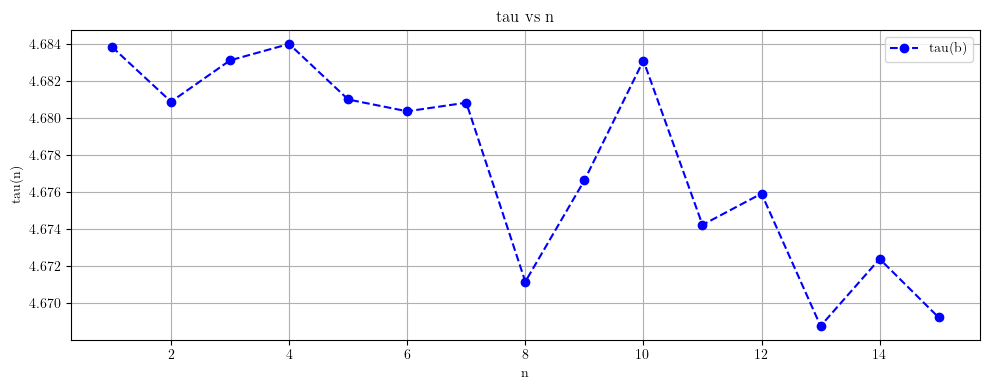

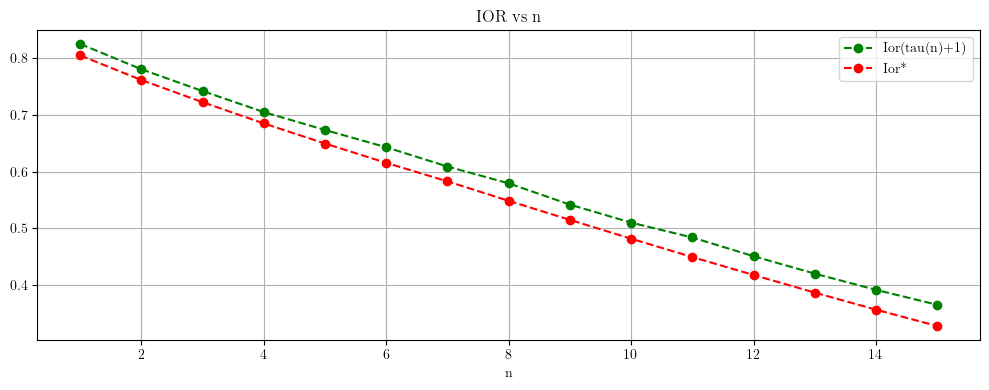

In [ ]:
data = [
    [1, 4.683840044655542, 0.8256461414542523, 0.80533],
    [2, 4.680882458727919, 0.7808823553663345, 0.76189],
    [3, 4.68311416439418, 0.7424058955597167, 0.7227600000000001],
    [4, 4.683997999067107, 0.7052997254847748, 0.6851999999999999],
    [5, 4.6810023448421125, 0.6736358641255311, 0.6497700000000001],
    [6, 4.680365005224655, 0.6431173585798166, 0.6155999999999997],
    [7, 4.680828991650454, 0.609136563367814, 0.5829],
    [8, 4.671170787936444, 0.5794442556929577, 0.54848],
    [9, 4.676633128266556, 0.5418272380386404, 0.51488],
    [10, 4.6831055971252775, 0.5100415677341186, 0.48162999999999995],
    [11, 4.674236497060614, 0.4837626713806173, 0.44918999999999987],
    [12, 4.675924295499224, 0.4507342252598998, 0.41752000000000006],
    [13, 4.668779254324395, 0.419918736082548, 0.3864000000000001],
    [14, 4.672399521818031, 0.3912598928512362, 0.35625],
    [15, 4.669241257943118, 0.3649136958141689, 0.32736999999999994],
]

x = [row[0] for row in data]
y1 = [row[1] for row in data]
y2 = [row[2] for row in data]
y3 = [row[3] for row in data]

plt.figure(figsize=(10, 4))
plt.plot(x, y1, 'o--', color='blue', label='tau(b)')
plt.xlabel("n")
plt.ylabel("tau(n)")
plt.title("tau vs n")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, y2, 'o--', color='green', label='Ior(tau(n)+1)')
plt.plot(x, y3, 'o--', color='red', label='Ior*')
plt.xlabel("n")
plt.ylabel("")
plt.title("IOR vs n")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Ejemplo de matriz de transición

### $j_1:$

In [ ]:
Opt = 5.3
cap = 10
m2 = 10
par = 0.0

MP = MarkovMatrix(Opt,cap,m2,par)

printt(MP,3)

### $j_2:$

In [ ]:
Opt = 7.8
cap = 10
m2 = 10
par = 0.0

MP = MarkovMatrix(Opt,cap,m2,par)

printt(MP,3)